In [2]:
import pandas as pd
import numpy as np
import json
import re
from wordcloud import WordCloud
from pandas.plotting import register_matplotlib_converters
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

font_path = 'C:/Windows/Fonts/malgun.ttf'
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font',family=font_name)

In [3]:
train = pd.read_json('C:\\localRepository\\ProjectDL\\data\\train.json', typ = 'frame')

In [5]:
train.to_csv('C:\\localRepository\\ProjectDL\\data\\melon_train.csv',index=True, encoding='utf-8')

In [6]:
train.tail(10)

,tags,id,plylst_title,songs,like_cnt,updt_date
115061,[까페],53627,카페에서 손님들이 궁금해하는노래^.^,"[138084, 388661, 586332, 244799, 152017, 46819...",489,2013-10-08 18:05:58.000
115062,"[힐링, 휴식, 기분전환]",2531,J pop처음 듣는 사람도 중독된 듯 빠져드는 j pop 리스트,"[584721, 278451, 495678, 388939, 118805, 44029...",344,2015-12-30 19:41:08.000
115063,"[드라마, 설렘, OST, 센치]",120713,들으면 설레는 드라마 및 영화 삽입곡&OST,"[458085, 208186, 260107, 643315, 535044, 12916...",9,2017-12-06 23:27:08.000
115064,[JPOP],145872,meltedmoon's tastes 1,"[68191, 231806, 642423, 652037, 522165, 139541...",4,2010-02-27 04:43:19.000
115065,"[설렘, 사랑]",135687,남자고백노래,"[287003, 408232, 625933, 152186, 543298, 22271...",14,2016-06-23 13:24:27.000
115066,"[록메탈, 밴드사운드, 록, 락메탈, 메탈, 락, extreme]",120325,METAL E'SM #2,"[429629, 441511, 612106, 516359, 691768, 38714...",3,2020-04-17 04:31:11.000
115067,[일렉],106976,빠른 리스너를 위한 따끈따끈한 최신 인기 EDM 모음!,"[321330, 216057, 534472, 240306, 331098, 23288...",13,2015-12-24 17:23:19.000
115068,"[담시, 가족, 눈물, 그리움, 주인공, 나의_이야기, 사랑, 친구]",11343,#1. 눈물이 앞을 가리는 나의_이야기,"[50512, 249024, 250608, 371171, 229942, 694943...",4,2019-08-16 20:59:22.000
115069,"[잔잔한, 버스, 퇴근버스, Pop, 풍경, 퇴근길]",131982,퇴근 버스에서 편히 들으면서 하루를 마무리하기에 좋은 POP,"[533534, 608114, 343608, 417140, 609009, 30217...",4,2019-10-25 23:40:42.000
115070,"[노래추천, 팝송추천, 팝송, 팝송모음]",100389,FAVORITE POPSONG!!!,"[26008, 456354, 324105, 89871, 135272, 143548,...",17,2020-04-18 20:35:06.000


In [7]:
df_song = train[['id', 'tags']]

# unnest tags
plylst_tag_map_unnest = np.dstack(
    (
        np.repeat(df_song.id.values, list(map(len, df_song.tags))), 
        np.concatenate(df_song.tags.values)
    )
)

# unnested 데이터프레임 생성 : plylst_tag_map
df_song = pd.DataFrame(data = plylst_tag_map_unnest[0], columns = df_song.columns)
df_song['id'] = df_song['id'].astype(str)

# unnest 객체 제거
del plylst_tag_map_unnest

In [8]:
df_song

,id,tags
0,61281,락
1,10532,추억
2,10532,회상
3,76951,까페
4,76951,잔잔한
...,...,...
476326,131982,퇴근길
476327,100389,노래추천
476328,100389,팝송추천
476329,100389,팝송


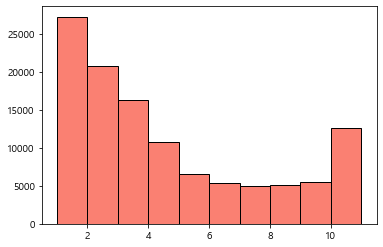

In [39]:
# 1. 플레이리스트 별 매핑 태그 수 count 테이블 생성 : plylst_tag_cnt
plylst_tag_cnt = pd.DataFrame(df_song.groupby('id').tags.nunique())

# 2. plotting
plt.hist(plylst_tag_cnt['tags'], range(1, 12), color = "salmon", edgecolor = "black")
plt.show()

In [10]:
round(plylst_tag_cnt.describe().loc[['min', '25%', '50%', 'mean', '75%', 'max', 'std']].transpose(), 2)

,min,25%,50%,mean,75%,max,std
tags,1.0,2.0,3.0,4.14,6.0,11.0,3.07


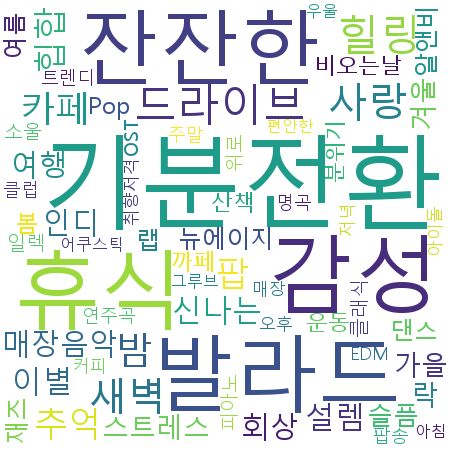

In [11]:
# 태그 별 매핑 빈도 수 저장 
tag_cnt = df_song.groupby('tags').tags.count().reset_index(name = 'mapping_cnt')
tag_cnt['tags'] = tag_cnt['tags'].astype(str)
tag_cnt['mapping_cnt'] = tag_cnt['mapping_cnt'].astype(int)

# 빈도 수가 1000회 이상인 태그만 저장
tag_cnt = tag_cnt[tag_cnt['mapping_cnt'] >= 1000]
word_count = list(zip(tag_cnt['tags'], tag_cnt['mapping_cnt']))

# plotting
wc = WordCloud(font_path = font_path, background_color = 'white', max_words = 100, width = 450, height = 450)
wc.generate_from_frequencies(dict(word_count)).to_image()

In [12]:
tag_cnt

,tags,mapping_cnt
1630,EDM,1528
2615,OST,2323
2737,Pop,3248
4970,가을,4042
5234,감성,11417
...,...,...
27194,피아노,1920
28557,회상,4579
28675,휴식,11215
28902,힐링,9783


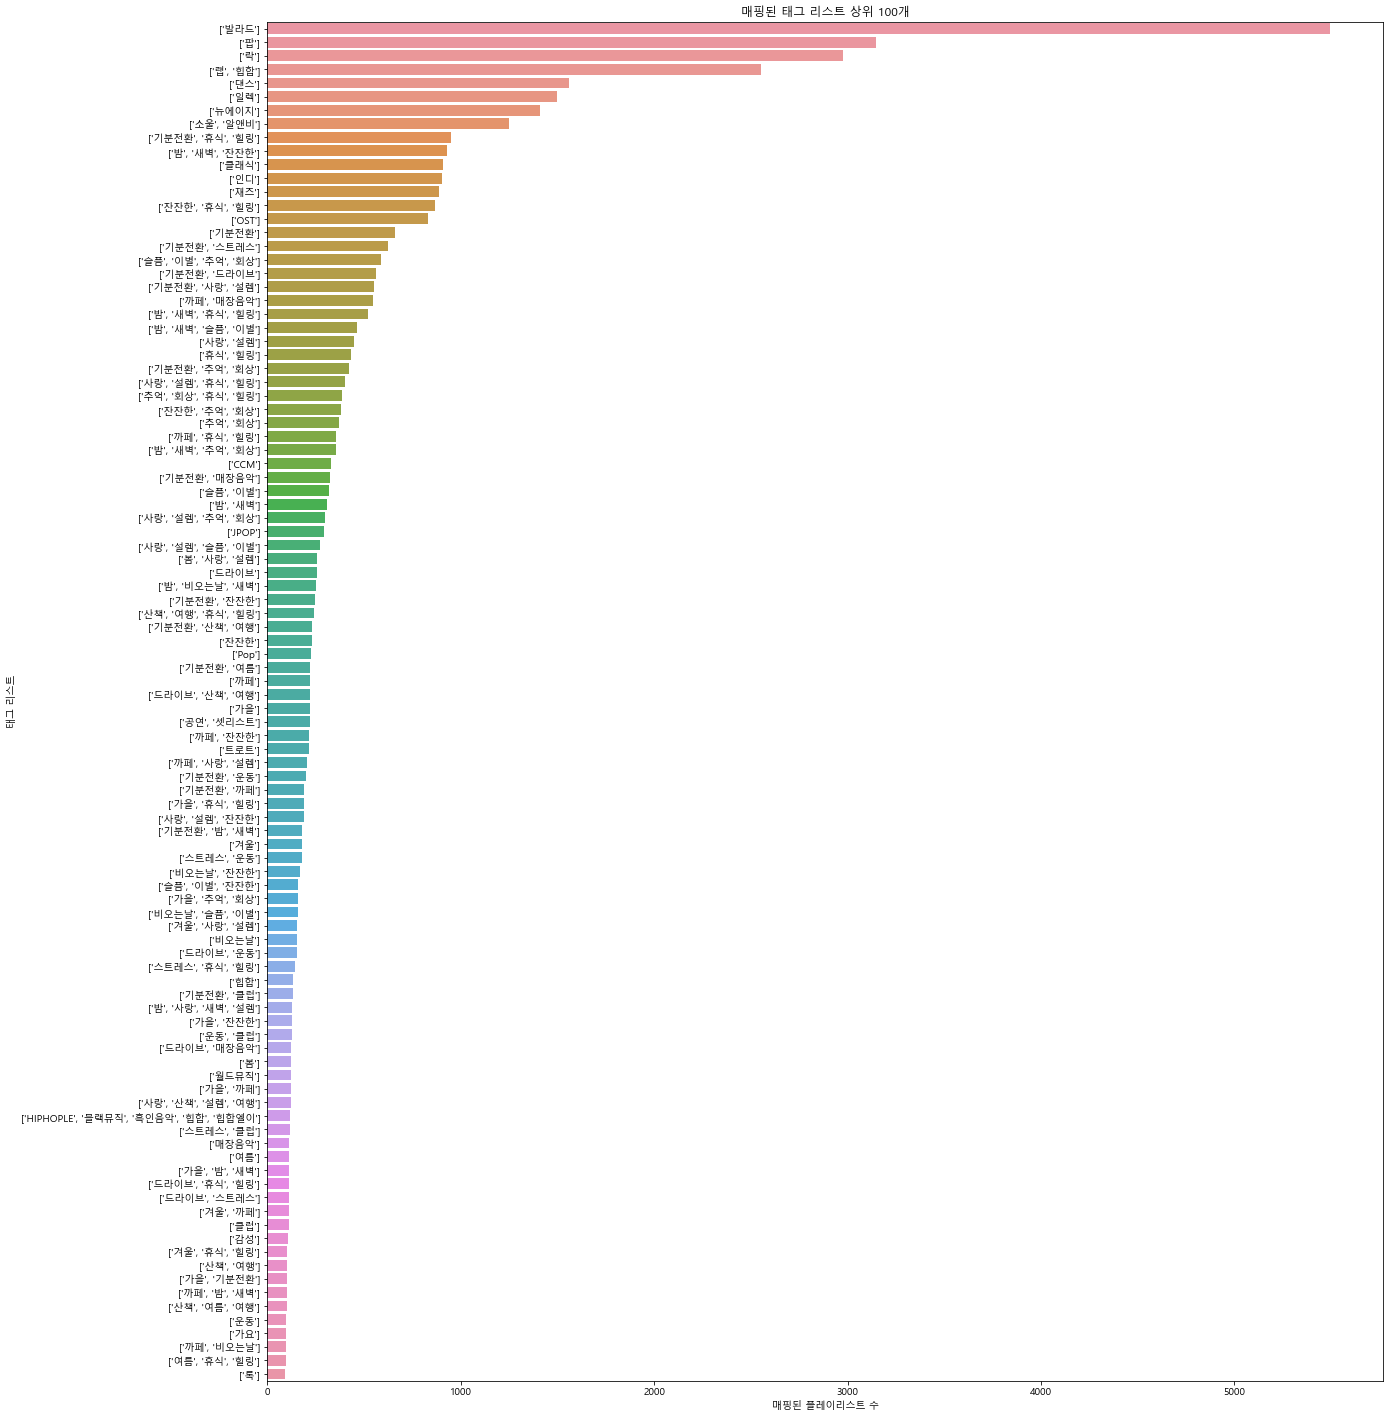

In [13]:
# 1. unnest 데이터프레임인 plylst_tag_map 테이블에서 태그 이름 정렬 후 list로 묶기
plylst_tag_list_sort = df_song.sort_values(by = ['id', 'tags']).groupby('id').tags.apply(list).reset_index(name = 'tag_list')

# 2. 집계를 위해 1번 테이블에서 list 타입을 문자열 타입으로 변경
plylst_tag_list_sort['tag_list'] = plylst_tag_list_sort['tag_list'].astype(str)

# 3. 태그 리스트 별 매핑되는 플레이리스트 수 집계 테이블 생성 : tag_list_plylst_cnt
tag_list_plylst_cnt = plylst_tag_list_sort.groupby('tag_list').id.nunique().reset_index(name = 'plylst_cnt')

# 4. 매핑 수 기준 상위 100개 필터링
tag_list_plylst_cnt = tag_list_plylst_cnt.nlargest(100, 'plylst_cnt')

# 5. plotting
plt.figure(figsize = (20, 25))
tag_list_plylst_cnt_plot = sns.barplot(y = 'tag_list', x = 'plylst_cnt', data = tag_list_plylst_cnt)
tag_list_plylst_cnt_plot.set_title('매핑된 태그 리스트 상위 100개')
tag_list_plylst_cnt_plot.set_xlabel('매핑된 플레이리스트 수')
tag_list_plylst_cnt_plot.set_ylabel('태그 리스트')
plt.show()

In [21]:
list_tag = tag_list_plylst_cnt.tag_list.to_list()
len(list_tag)

100

In [22]:
# 장르를 제거한 감정 태그만 추출하기
genre = ['발라드', '팝', '락', '랩', '힙합', '일렉', '뉴에이지', '소울', '알앤비', '클래식', '인디', '재즈', 'OST', 'CCM', 'JPOP', 'POP', '트로트', '월드뮤직', '가요', '록', '댄스', '매장음악', 'Pop', '공연', '셋리스트']
only_genre = []

for t in list_tag:
    for g in genre:
        if g in t:
            only_genre.append(t)
emo_tag = set(list_tag) - set(only_genre) 
emo_tag_list = list(emo_tag)
print(emo_tag_list), len(emo_tag_list)

["['추억', '회상', '휴식', '힐링']", "['스트레스', '운동']", "['사랑', '설렘', '잔잔한']", "['감성']", "['기분전환', '드라이브']", "['기분전환', '추억', '회상']", "['사랑', '설렘', '추억', '회상']", "['밤', '새벽', '휴식', '힐링']", "['기분전환']", "['드라이브', '휴식', '힐링']", "['기분전환', '사랑', '설렘']", "['가을', '휴식', '힐링']", "['기분전환', '휴식', '힐링']", "['사랑', '설렘', '휴식', '힐링']", "['기분전환', '까페']", "['스트레스', '휴식', '힐링']", "['비오는날', '슬픔', '이별']", "['까페', '잔잔한']", "['겨울', '사랑', '설렘']", "['사랑', '산책', '설렘', '여행']", "['스트레스', '클럽']", "['사랑', '설렘', '슬픔', '이별']", "['기분전환', '밤', '새벽']", "['잔잔한', '추억', '회상']", "['기분전환', '여름']", "['까페']", "['드라이브', '산책', '여행']", "['기분전환', '클럽']", "['산책', '여름', '여행']", "['클럽']", "['기분전환', '스트레스']", "['가을', '까페']", "['가을', '기분전환']", "['휴식', '힐링']", "['운동', '클럽']", "['가을', '추억', '회상']", "['추억', '회상']", "['드라이브']", "['밤', '새벽', '잔잔한']", "['기분전환', '운동']", "['드라이브', '스트레스']", "['사랑', '설렘']", "['산책', '여행', '휴식', '힐링']", "['슬픔', '이별', '추억', '회상']", "['봄']", "['밤', '새벽', '추억', '회상']", "['밤', '사랑', '새벽', '설렘']", "['까페', '밤', '새벽']", "['밤', '

(None, 74)

In [23]:
# 추출한 감정 태그를 DataFrame으로 만들기
emo_tag_df = pd.DataFrame(data=emo_tag_list, columns=['tag_list'])
emo_tag_df

,tag_list
0,"['추억', '회상', '휴식', '힐링']"
1,"['스트레스', '운동']"
2,"['사랑', '설렘', '잔잔한']"
3,['감성']
4,"['기분전환', '드라이브']"
...,...
69,"['겨울', '휴식', '힐링']"
70,"['비오는날', '잔잔한']"
71,"['기분전환', '산책', '여행']"
72,"['밤', '새벽']"


In [24]:
tag_list_plylst_cnt

,tag_list,plylst_cnt
51670,['발라드'],5497
58918,['팝'],3147
48836,['락'],2977
48990,"['랩', '힙합']",2550
45955,['댄스'],1558
...,...,...
57210,['운동'],97
17921,['가요'],94
41115,"['까페', '비오는날']",94
56499,"['여름', '휴식', '힐링']",94


In [25]:
# tag_list_plylst_cnt와 emo_tag_df를 'tag_list'를 기준으로 합치기
emo_tag_plylst_cnt = pd.merge(emo_tag_df,tag_list_plylst_cnt, how='inner',on='tag_list')

# 감정 태그 리스트 별 플레이리스트 수가 많은 순서대로 정렬 
emo_tag_plylst_cnt = emo_tag_plylst_cnt.sort_values(by=['plylst_cnt'], ascending=False)
emo_tag_plylst_cnt

,tag_list,plylst_cnt
12,"['기분전환', '휴식', '힐링']",950
38,"['밤', '새벽', '잔잔한']",926
58,"['잔잔한', '휴식', '힐링']",865
8,['기분전환'],657
30,"['기분전환', '스트레스']",622
...,...,...
28,"['산책', '여름', '여행']",100
47,"['까페', '밤', '새벽']",100
51,['운동'],97
52,"['까페', '비오는날']",94


In [37]:
set2 = sns.color_palette('Set3')
set2

[(0.5529411764705883, 0.8274509803921568, 0.7803921568627451),
 (1.0, 1.0, 0.7019607843137254),
 (0.7450980392156863, 0.7294117647058823, 0.8549019607843137),
 (0.984313725490196, 0.5019607843137255, 0.4470588235294118),
 (0.5019607843137255, 0.6941176470588235, 0.8274509803921568),
 (0.9921568627450981, 0.7058823529411765, 0.3843137254901961),
 (0.7019607843137254, 0.8705882352941177, 0.4117647058823529),
 (0.9882352941176471, 0.803921568627451, 0.8980392156862745),
 (0.8509803921568627, 0.8509803921568627, 0.8509803921568627),
 (0.7372549019607844, 0.5019607843137255, 0.7411764705882353),
 (0.8, 0.9215686274509803, 0.7725490196078432),
 (1.0, 0.9294117647058824, 0.43529411764705883)]

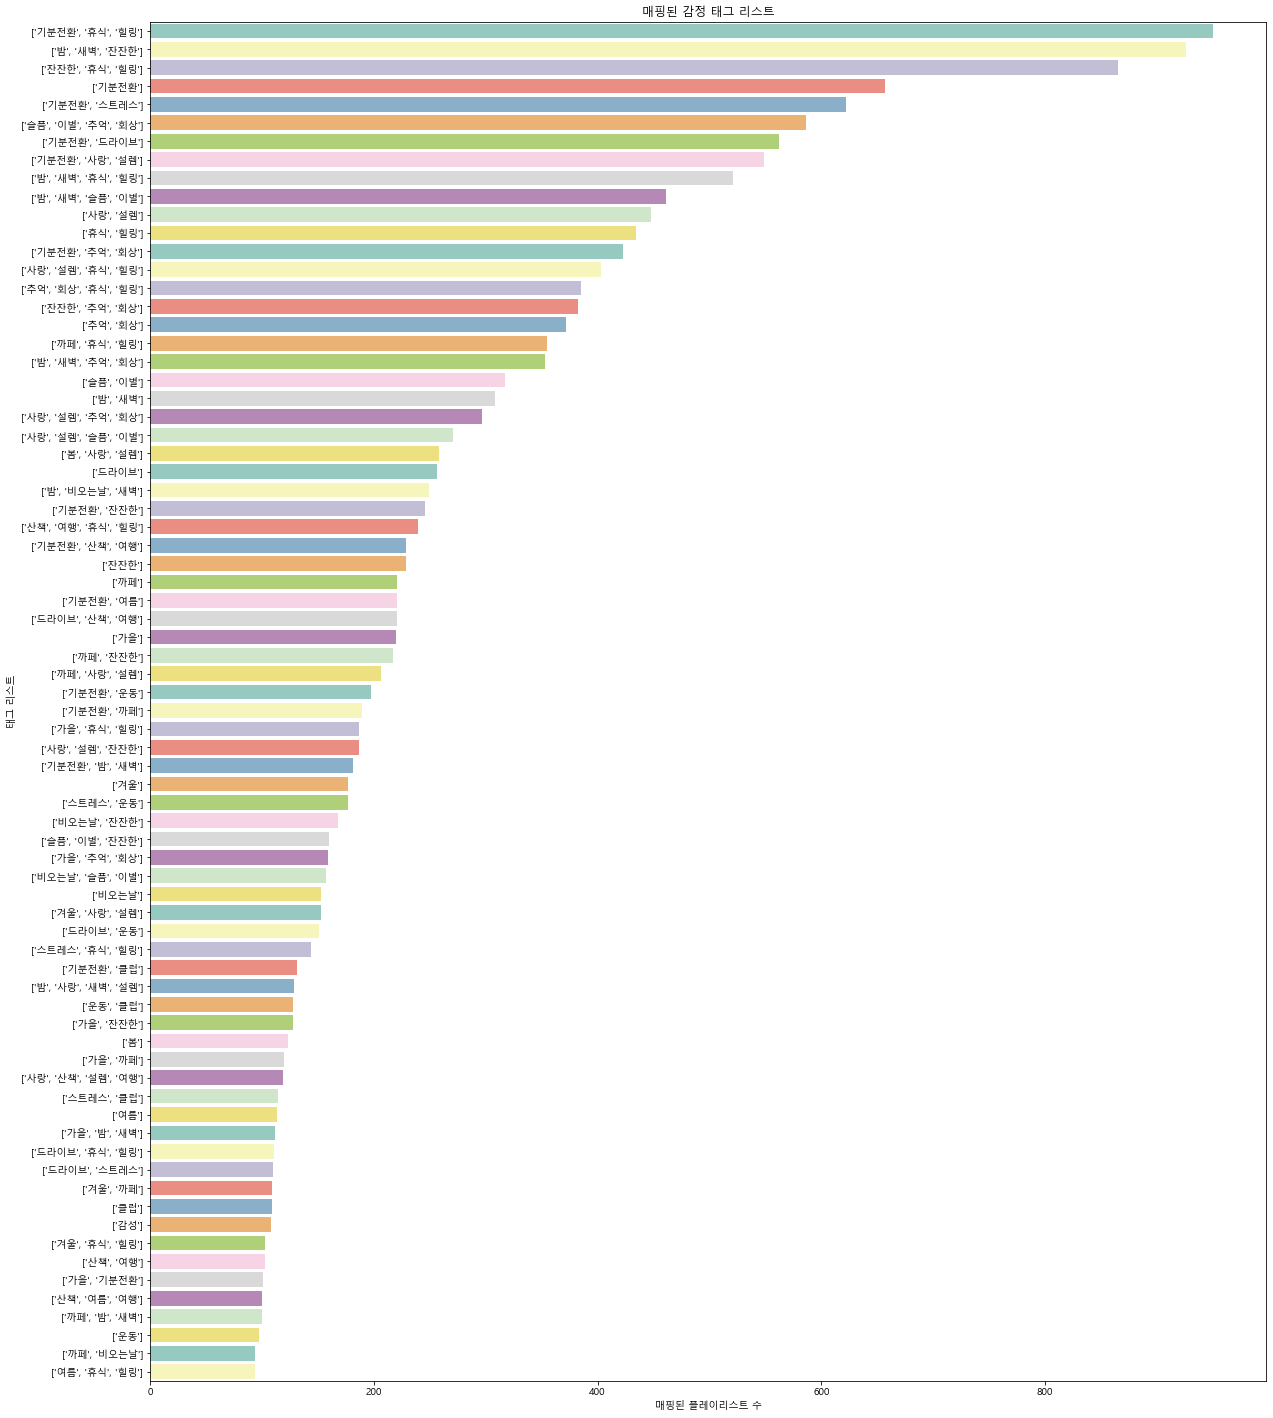

In [38]:
# 감정 태그 리스트 별 플레이리스트 개수 plot 그리기
plt.figure(figsize = (20, 25))
tag_list_plylst_cnt_plot = sns.barplot(y = 'tag_list', x = 'plylst_cnt', data = emo_tag_plylst_cnt, palette=set2)
tag_list_plylst_cnt_plot.set_title('매핑된 감정 태그 리스트')
tag_list_plylst_cnt_plot.set_xlabel('매핑된 플레이리스트 수')
tag_list_plylst_cnt_plot.set_ylabel('태그 리스트')
plt.show()

### train의 tags 대괄호 제거

In [18]:
tags_lists = train.tags.to_list()
tags_lists

[['락'],
 ['추억', '회상'],
 ['까페', '잔잔한'],
 ['연말',
  '눈오는날',
  '캐럴',
  '분위기',
  '따듯한',
  '크리스마스캐럴',
  '겨울노래',
  '크리스마스',
  '겨울왕국',
  '크리스마스송'],
 ['댄스'],
 ['운동', '드라이브', 'Pop', '트로피컬하우스', '힐링', '기분전환', '2017', '팝', '트렌드', '일렉'],
 ['짝사랑', '취향저격', '슬픔', '고백', '사랑', '이별'],
 ['잔잔한', '추억', '회상'],
 ['일렉트로니카', '포크', '메탈', '락', '댄스', '인디'],
 ['록', 'Metal', '이일우', 'M에센셜', '메탈', 'Rock', '락'],
 ['kpop', '댄스', '걸그룹댄스', '스트레스해소'],
 ['새해', '여행', '프로필음악', '카카오톡', '기분전환', '소원', '프로필', '소망', '다짐', '카톡'],
 ['듣고', '우울', '힐링', '이거', '힘내'],
 ['힙합', '느낌있는', '밤', '새벽', 'RnB', '감각적인', '드라이브', '국내', '그루브한'],
 ['가을', '재즈'],
 ['락'],
 ['감성', '질리지않는', '나만알고싶은', 'Pop'],
 ['봄', '설렘', '사랑'],
 ['비오는날', '누군가생각날때'],
 ['스밍', '목록', '폐막식', '올림픽', '엑소'],
 ['조용히', '혼자', '또는', '새벽감성', '고민', '맥주한잔'],
 ['카페', '재즈', '잔잔한'],
 ['OST'],
 ['댄스'],
 ['감성', '어쿠스틱', '잔잔한', '새벽', '편안한', '인디', '밤'],
 ['잔잔한', '밤', '새벽'],
 ['힐링', '드라이브', '에너지', '인디', '여행'],
 ['듀엣', '취향저격', '달달', '피쳐링', '사랑', '남녀'],
 ['까페', '설렘', '사랑'],
 ['힙합', '신인', '국힙', '인디', 

In [19]:
tags_tuple = tuple(tags_lists)
tags_tuple

(['락'],
 ['추억', '회상'],
 ['까페', '잔잔한'],
 ['연말',
  '눈오는날',
  '캐럴',
  '분위기',
  '따듯한',
  '크리스마스캐럴',
  '겨울노래',
  '크리스마스',
  '겨울왕국',
  '크리스마스송'],
 ['댄스'],
 ['운동', '드라이브', 'Pop', '트로피컬하우스', '힐링', '기분전환', '2017', '팝', '트렌드', '일렉'],
 ['짝사랑', '취향저격', '슬픔', '고백', '사랑', '이별'],
 ['잔잔한', '추억', '회상'],
 ['일렉트로니카', '포크', '메탈', '락', '댄스', '인디'],
 ['록', 'Metal', '이일우', 'M에센셜', '메탈', 'Rock', '락'],
 ['kpop', '댄스', '걸그룹댄스', '스트레스해소'],
 ['새해', '여행', '프로필음악', '카카오톡', '기분전환', '소원', '프로필', '소망', '다짐', '카톡'],
 ['듣고', '우울', '힐링', '이거', '힘내'],
 ['힙합', '느낌있는', '밤', '새벽', 'RnB', '감각적인', '드라이브', '국내', '그루브한'],
 ['가을', '재즈'],
 ['락'],
 ['감성', '질리지않는', '나만알고싶은', 'Pop'],
 ['봄', '설렘', '사랑'],
 ['비오는날', '누군가생각날때'],
 ['스밍', '목록', '폐막식', '올림픽', '엑소'],
 ['조용히', '혼자', '또는', '새벽감성', '고민', '맥주한잔'],
 ['카페', '재즈', '잔잔한'],
 ['OST'],
 ['댄스'],
 ['감성', '어쿠스틱', '잔잔한', '새벽', '편안한', '인디', '밤'],
 ['잔잔한', '밤', '새벽'],
 ['힐링', '드라이브', '에너지', '인디', '여행'],
 ['듀엣', '취향저격', '달달', '피쳐링', '사랑', '남녀'],
 ['까페', '설렘', '사랑'],
 ['힙합', '신인', '국힙', '인디', 

In [20]:
tags_df = pd.DataFrame(tags_tuple)
tags_df

,0,1,2,3,4,5,6,7,8,9,10
0,락,None,None,None,None,None,None,None,None,None,None
1,추억,회상,None,None,None,None,None,None,None,None,None
2,까페,잔잔한,None,None,None,None,None,None,None,None,None
3,연말,눈오는날,캐럴,분위기,따듯한,크리스마스캐럴,겨울노래,크리스마스,겨울왕국,크리스마스송,None
4,댄스,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...
115066,록메탈,밴드사운드,록,락메탈,메탈,락,extreme,None,None,None,None
115067,일렉,None,None,None,None,None,None,None,None,None,None
115068,담시,가족,눈물,그리움,주인공,나의_이야기,사랑,친구,None,None,None
115069,잔잔한,버스,퇴근버스,Pop,풍경,퇴근길,None,None,None,None,None


In [21]:
tags_df.columns = ['tag1', 'tag2', 'tag3', 'tag4', 'tag5', 'tag6', 'tag7', 'tag8', 'tag9', 'tag10', 'tag11']
tags_df

,tag1,tag2,tag3,tag4,tag5,tag6,tag7,tag8,tag9,tag10,tag11
0,락,None,None,None,None,None,None,None,None,None,None
1,추억,회상,None,None,None,None,None,None,None,None,None
2,까페,잔잔한,None,None,None,None,None,None,None,None,None
3,연말,눈오는날,캐럴,분위기,따듯한,크리스마스캐럴,겨울노래,크리스마스,겨울왕국,크리스마스송,None
4,댄스,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...
115066,록메탈,밴드사운드,록,락메탈,메탈,락,extreme,None,None,None,None
115067,일렉,None,None,None,None,None,None,None,None,None,None
115068,담시,가족,눈물,그리움,주인공,나의_이야기,사랑,친구,None,None,None
115069,잔잔한,버스,퇴근버스,Pop,풍경,퇴근길,None,None,None,None,None


In [22]:
cols = ['tag1', 'tag2', 'tag3', 'tag4', 'tag5', 'tag6', 'tag7', 'tag8', 'tag9', 'tag10', 'tag11']
tags_df = tags_df[cols].apply(lambda row: ','.join(row.values.astype(str)), axis=1)

In [23]:
tags_df = pd.DataFrame(tags_df, columns=['tag'])
tags_df

,tag
0,"락,None,None,None,None,None,None,None,None,None..."
1,"추억,회상,None,None,None,None,None,None,None,None,..."
2,"까페,잔잔한,None,None,None,None,None,None,None,None..."
3,"연말,눈오는날,캐럴,분위기,따듯한,크리스마스캐럴,겨울노래,크리스마스,겨울왕국,크리스..."
4,"댄스,None,None,None,None,None,None,None,None,Non..."
...,...
115066,"록메탈,밴드사운드,록,락메탈,메탈,락,extreme,None,None,None,None"
115067,"일렉,None,None,None,None,None,None,None,None,Non..."
115068,"담시,가족,눈물,그리움,주인공,나의_이야기,사랑,친구,None,None,None"
115069,"잔잔한,버스,퇴근버스,Pop,풍경,퇴근길,None,None,None,None,None"


In [24]:
tags_df['tag'] = tags_df['tag'].str.replace('None,', '')
tags_df['tag'] = tags_df['tag'].str.replace(',None', '')
tags_df['tag'] = tags_df['tag'].str.replace(',', ', ')
tags_df

,tag
0,락
1,"추억, 회상"
2,"까페, 잔잔한"
3,"연말, 눈오는날, 캐럴, 분위기, 따듯한, 크리스마스캐럴, 겨울노래, 크리스마스, ..."
4,댄스
...,...
115066,"록메탈, 밴드사운드, 록, 락메탈, 메탈, 락, extreme"
115067,일렉
115068,"담시, 가족, 눈물, 그리움, 주인공, 나의_이야기, 사랑, 친구"
115069,"잔잔한, 버스, 퇴근버스, Pop, 풍경, 퇴근길"


### 대괄호 제거 후 다시 train에 추가(이름: new_train으로 변경)

In [25]:
new_train = pd.concat([train, tags_df], axis=1)
new_train

,tags,id,plylst_title,songs,like_cnt,updt_date,tag
0,[락],61281,여행같은 음악,"[525514, 129701, 383374, 562083, 297861, 13954...",71,2013-12-19 18:36:19.000,락
1,"[추억, 회상]",10532,요즘 너 말야,"[432406, 675945, 497066, 120377, 389529, 24427...",1,2014-12-02 16:19:42.000,"추억, 회상"
2,"[까페, 잔잔한]",76951,"편하게, 잔잔하게 들을 수 있는 곡.-","[83116, 276692, 166267, 186301, 354465, 256598...",17,2017-08-28 07:09:34.000,"까페, 잔잔한"
3,"[연말, 눈오는날, 캐럴, 분위기, 따듯한, 크리스마스캐럴, 겨울노래, 크리스마스,...",147456,크리스마스 분위기에 흠뻑 취하고 싶을때,"[394031, 195524, 540149, 287984, 440773, 10033...",33,2019-12-05 15:15:18.000,"연말, 눈오는날, 캐럴, 분위기, 따듯한, 크리스마스캐럴, 겨울노래, 크리스마스, ..."
4,[댄스],27616,추억의 노래 ㅋ,"[159327, 553610, 5130, 645103, 294435, 100657,...",9,2011-10-25 13:54:56.000,댄스
...,...,...,...,...,...,...,...
115066,"[록메탈, 밴드사운드, 록, 락메탈, 메탈, 락, extreme]",120325,METAL E'SM #2,"[429629, 441511, 612106, 516359, 691768, 38714...",3,2020-04-17 04:31:11.000,"록메탈, 밴드사운드, 록, 락메탈, 메탈, 락, extreme"
115067,[일렉],106976,빠른 리스너를 위한 따끈따끈한 최신 인기 EDM 모음!,"[321330, 216057, 534472, 240306, 331098, 23288...",13,2015-12-24 17:23:19.000,일렉
115068,"[담시, 가족, 눈물, 그리움, 주인공, 나의_이야기, 사랑, 친구]",11343,#1. 눈물이 앞을 가리는 나의_이야기,"[50512, 249024, 250608, 371171, 229942, 694943...",4,2019-08-16 20:59:22.000,"담시, 가족, 눈물, 그리움, 주인공, 나의_이야기, 사랑, 친구"
115069,"[잔잔한, 버스, 퇴근버스, Pop, 풍경, 퇴근길]",131982,퇴근 버스에서 편히 들으면서 하루를 마무리하기에 좋은 POP,"[533534, 608114, 343608, 417140, 609009, 30217...",4,2019-10-25 23:40:42.000,"잔잔한, 버스, 퇴근버스, Pop, 풍경, 퇴근길"


In [26]:
new_train = new_train.drop(columns=['tags'])
new_train

,id,plylst_title,songs,like_cnt,updt_date,tag
0,61281,여행같은 음악,"[525514, 129701, 383374, 562083, 297861, 13954...",71,2013-12-19 18:36:19.000,락
1,10532,요즘 너 말야,"[432406, 675945, 497066, 120377, 389529, 24427...",1,2014-12-02 16:19:42.000,"추억, 회상"
2,76951,"편하게, 잔잔하게 들을 수 있는 곡.-","[83116, 276692, 166267, 186301, 354465, 256598...",17,2017-08-28 07:09:34.000,"까페, 잔잔한"
3,147456,크리스마스 분위기에 흠뻑 취하고 싶을때,"[394031, 195524, 540149, 287984, 440773, 10033...",33,2019-12-05 15:15:18.000,"연말, 눈오는날, 캐럴, 분위기, 따듯한, 크리스마스캐럴, 겨울노래, 크리스마스, ..."
4,27616,추억의 노래 ㅋ,"[159327, 553610, 5130, 645103, 294435, 100657,...",9,2011-10-25 13:54:56.000,댄스
...,...,...,...,...,...,...
115066,120325,METAL E'SM #2,"[429629, 441511, 612106, 516359, 691768, 38714...",3,2020-04-17 04:31:11.000,"록메탈, 밴드사운드, 록, 락메탈, 메탈, 락, extreme"
115067,106976,빠른 리스너를 위한 따끈따끈한 최신 인기 EDM 모음!,"[321330, 216057, 534472, 240306, 331098, 23288...",13,2015-12-24 17:23:19.000,일렉
115068,11343,#1. 눈물이 앞을 가리는 나의_이야기,"[50512, 249024, 250608, 371171, 229942, 694943...",4,2019-08-16 20:59:22.000,"담시, 가족, 눈물, 그리움, 주인공, 나의_이야기, 사랑, 친구"
115069,131982,퇴근 버스에서 편히 들으면서 하루를 마무리하기에 좋은 POP,"[533534, 608114, 343608, 417140, 609009, 30217...",4,2019-10-25 23:40:42.000,"잔잔한, 버스, 퇴근버스, Pop, 풍경, 퇴근길"


### emo_tag_plylst_cnt의 tag_list 대괄호 제거

In [27]:
# df['제목'].str[0].loc[0]
emo_tag_plylst_cnt['tag_list'].str[0].loc[0]

'['

In [28]:
# df['제목'].str.replace(pat=r'[^\w]',repl=r' ',regex=True)
emo_tag_plylst_cnt['tag_list'] = emo_tag_plylst_cnt['tag_list'].str.replace(pat=r'[^\w]',repl=r' ',regex=True)
emo_tag_plylst_cnt

,tag_list,plylst_cnt
10,기분전환 휴식 힐링,950
52,밤 새벽 잔잔한,926
8,잔잔한 휴식 힐링,865
68,기분전환,657
44,기분전환 스트레스,622
...,...,...
41,산책 여름 여행,100
56,까페 밤 새벽,100
26,운동,97
62,여름 휴식 힐링,94


In [29]:
emo_tag_plylst_cnt['tag_list'] = emo_tag_plylst_cnt['tag_list'].str.strip()
emo_tag_plylst_cnt['tag_list'] = emo_tag_plylst_cnt['tag_list'].str.replace(' ', ',')
emo_tag_plylst_cnt['tag_list'] = emo_tag_plylst_cnt['tag_list'].str.replace(',,,,', ',')

emo_tag_plylst_cnt

,tag_list,plylst_cnt
10,"기분전환,휴식,힐링",950
52,"밤,새벽,잔잔한",926
8,"잔잔한,휴식,힐링",865
68,기분전환,657
44,"기분전환,스트레스",622
...,...,...
41,"산책,여름,여행",100
56,"까페,밤,새벽",100
26,운동,97
62,"여름,휴식,힐링",94


In [30]:
emo_tag_plylst_cnt['tag_list'] = emo_tag_plylst_cnt['tag_list'].str.replace(',', ', ')
emo_tag_plylst_cnt

,tag_list,plylst_cnt
10,"기분전환, 휴식, 힐링",950
52,"밤, 새벽, 잔잔한",926
8,"잔잔한, 휴식, 힐링",865
68,기분전환,657
44,"기분전환, 스트레스",622
...,...,...
41,"산책, 여름, 여행",100
56,"까페, 밤, 새벽",100
26,운동,97
62,"여름, 휴식, 힐링",94


In [31]:
new_train

,id,plylst_title,songs,like_cnt,updt_date,tag
0,61281,여행같은 음악,"[525514, 129701, 383374, 562083, 297861, 13954...",71,2013-12-19 18:36:19.000,락
1,10532,요즘 너 말야,"[432406, 675945, 497066, 120377, 389529, 24427...",1,2014-12-02 16:19:42.000,"추억, 회상"
2,76951,"편하게, 잔잔하게 들을 수 있는 곡.-","[83116, 276692, 166267, 186301, 354465, 256598...",17,2017-08-28 07:09:34.000,"까페, 잔잔한"
3,147456,크리스마스 분위기에 흠뻑 취하고 싶을때,"[394031, 195524, 540149, 287984, 440773, 10033...",33,2019-12-05 15:15:18.000,"연말, 눈오는날, 캐럴, 분위기, 따듯한, 크리스마스캐럴, 겨울노래, 크리스마스, ..."
4,27616,추억의 노래 ㅋ,"[159327, 553610, 5130, 645103, 294435, 100657,...",9,2011-10-25 13:54:56.000,댄스
...,...,...,...,...,...,...
115066,120325,METAL E'SM #2,"[429629, 441511, 612106, 516359, 691768, 38714...",3,2020-04-17 04:31:11.000,"록메탈, 밴드사운드, 록, 락메탈, 메탈, 락, extreme"
115067,106976,빠른 리스너를 위한 따끈따끈한 최신 인기 EDM 모음!,"[321330, 216057, 534472, 240306, 331098, 23288...",13,2015-12-24 17:23:19.000,일렉
115068,11343,#1. 눈물이 앞을 가리는 나의_이야기,"[50512, 249024, 250608, 371171, 229942, 694943...",4,2019-08-16 20:59:22.000,"담시, 가족, 눈물, 그리움, 주인공, 나의_이야기, 사랑, 친구"
115069,131982,퇴근 버스에서 편히 들으면서 하루를 마무리하기에 좋은 POP,"[533534, 608114, 343608, 417140, 609009, 30217...",4,2019-10-25 23:40:42.000,"잔잔한, 버스, 퇴근버스, Pop, 풍경, 퇴근길"


In [32]:
emo_tag_plylst_cnt

,tag_list,plylst_cnt
10,"기분전환, 휴식, 힐링",950
52,"밤, 새벽, 잔잔한",926
8,"잔잔한, 휴식, 힐링",865
68,기분전환,657
44,"기분전환, 스트레스",622
...,...,...
41,"산책, 여름, 여행",100
56,"까페, 밤, 새벽",100
26,운동,97
62,"여름, 휴식, 힐링",94


### new_train과 emo_tag_plylst_cnt를 tag를 기준으로(감정 태그만) 병합하기

In [33]:
emo_tag_train = pd.merge(new_train, emo_tag_plylst_cnt, left_on='tag', right_on='tag_list')
emo_tag_train.sample(10)

,id,plylst_title,songs,like_cnt,updt_date,tag,tag_list,plylst_cnt
5837,42144,만사형통 출근길 뮤직,"[247679, 57110, 464051, 519385, 382821, 43248,...",11,2015-01-06 14:54:19.000,"기분전환, 까페","기분전환, 까페",189
6632,107867,"[작곡가]블랙아이드 필승 《댄스, 발라드》","[550440, 598880, 521139, 209047, 216505, 7766,...",30,2016-10-24 01:28:29.000,"드라이브, 운동","드라이브, 운동",151
2172,57289,듣기 좋은 쨰즈 음악,"[168344, 44041, 702340, 545797]",2,2016-01-08 08:49:46.000,까페,까페,221
83,36037,아날로그감성,"[324814, 437566, 71012, 253755, 319820, 557552...",0,2015-01-16 16:09:31.000,"추억, 회상","추억, 회상",372
1942,8597,jjjjj,"[29842, 615561, 422091, 470684, 248226, 388635...",0,2015-02-14 14:06:28.000,기분전환,기분전환,657
1475,18085,"♤상큼한아침,지하철♤","[35165, 614756, 500718, 95893, 310677, 657288,...",9,2012-04-11 02:16:42.000,기분전환,기분전환,657
3442,64850,"rubato, 02","[273933, 41842, 416006, 539907, 508285, 267112...",6,2018-09-11 12:49:24.000,"기분전환, 밤, 새벽","기분전환, 밤, 새벽",181
1048,73290,드라이브할 때 듣기 좋은 노래,"[455155, 158359, 416755, 78894, 183078, 520620...",13,2018-09-30 02:40:31.000,드라이브,드라이브,256
722,135293,tvn 아홉수소년 삽입곡,"[368069, 705494, 72208, 177825, 265584, 576478...",9,2014-09-17 08:16:31.000,"잔잔한, 추억, 회상","잔잔한, 추억, 회상",382
4984,101290,참깨솜사탕자자,"[650207, 644461, 300686, 203558, 56325, 656134...",1,2016-12-09 18:39:22.000,비오는날,비오는날,153


In [34]:
emo_tag_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6673 entries, 0 to 6672
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            6673 non-null   int64 
 1   plylst_title  6673 non-null   object
 2   songs         6673 non-null   object
 3   like_cnt      6673 non-null   int64 
 4   updt_date     6673 non-null   object
 5   tag           6673 non-null   object
 6   tag_list      6673 non-null   object
 7   plylst_cnt    6673 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 469.2+ KB


In [35]:
like_mean = emo_tag_train.like_cnt.mean()
like_mean

66.2580548478945

In [36]:
like_median = emo_tag_train.like_cnt.median()
like_median

6.0

In [37]:
emo_tag_train = emo_tag_train[emo_tag_train['like_cnt'] > 1]
emo_tag_train

,id,plylst_title,songs,like_cnt,updt_date,tag,tag_list,plylst_cnt
1,111944,신화를 추억하며,"[23743, 698749, 402171, 421925, 388924, 102519...",12,2015-07-12 13:49:22.000,"추억, 회상","추억, 회상",372
3,46611,아버지 어머니께 바치는 노래,"[138932, 176304, 473514, 78625, 251980, 212909...",17,2015-10-23 19:40:50.000,"추억, 회상","추억, 회상",372
4,20864,추억에 젖는 25살의 학창시절,"[391924, 629705, 198747, 506139, 333925, 38356...",5,2015-02-27 03:10:13.000,"추억, 회상","추억, 회상",372
6,12697,추억의ost,"[636163, 354666, 106249, 320601, 386522, 41898...",3,2014-11-15 18:42:50.000,"추억, 회상","추억, 회상",372
7,15920,토토가 덕분에 다시듣는 명곡들!,"[371691, 326088, 438424, 539090, 275179, 82293...",19,2014-12-22 17:24:42.000,"추억, 회상","추억, 회상",372
...,...,...,...,...,...,...,...,...
6667,90220,스트레스 저리 비켜!,"[700090, 433453, 125822, 440239, 193571, 27358...",30,2017-03-17 12:46:05.000,"기분전환, 스트레스","기분전환, 스트레스",622
6669,101698,스트레스엔 스타리그BGM!!,"[596414, 494891, 524265, 211325, 652662, 55421...",11,2017-02-02 16:31:15.000,"기분전환, 스트레스","기분전환, 스트레스",622
6670,4504,80년생들은 한번쯤 흥얼거렸을 법한 스트레스 해소 가요,"[689057, 123294, 263272, 14156, 615586, 80656,...",277,2015-09-12 05:05:19.000,"기분전환, 스트레스","기분전환, 스트레스",622
6671,38264,선정성 안무로 방송금지된 걸그룹 노래모음,"[104087, 233074, 527255, 34363, 284159, 447424...",49,2015-11-13 07:29:12.000,"기분전환, 스트레스","기분전환, 스트레스",622


In [46]:
emo_tag_train.to_csv('./data/emo_tag_train.csv', encoding='utf-8')

In [45]:
emo_tag_train.groupby('tag')['plylst_title'].count()

tag
가을              149
가을, 까페          115
가을, 잔잔한         111
감성               72
겨울              136
겨울, 까페          106
기분전환            445
기분전환, 까페        162
기분전환, 드라이브      415
기분전환, 밤, 새벽     160
기분전환, 스트레스        6
기분전환, 운동        189
기분전환, 잔잔한       107
까페              156
까페, 잔잔한         193
드라이브            182
드라이브, 스트레스        1
드라이브, 운동        146
밤, 새벽           219
봄                95
비오는날            118
비오는날, 슬픔, 이별    147
비오는날, 잔잔한       146
사랑, 설렘, 잔잔한      14
산책, 여행           16
스트레스, 운동        172
슬픔, 이별          247
슬픔, 이별, 잔잔한     144
여름               80
운동               86
잔잔한             145
잔잔한, 추억, 회상     308
추억, 회상          277
클럽               98
휴식, 힐링           74
Name: plylst_title, dtype: int64

In [49]:
emo_tag_train2 = pd.read_csv('./data/emo_tag_train2.csv', encoding='utf-8', index_col=0)
emo_tag_train2

,id,plylst_title,songs,tag,plylst_cnt,Emotion
0,10532,요즘 너 말야,"[432406, 675945, 497066, 120377, 389529, 24427...","추억, 회상",372,슬픔
1,111944,신화를 추억하며,"[23743, 698749, 402171, 421925, 388924, 102519...","추억, 회상",372,슬픔
2,148400,돌아가고 싶다..,"[94749, 521739, 447225, 395771, 49682, 161517,...","추억, 회상",372,슬픔
3,46611,아버지 어머니께 바치는 노래,"[138932, 176304, 473514, 78625, 251980, 212909...","추억, 회상",372,슬픔
4,20864,추억에 젖는 25살의 학창시절,"[391924, 629705, 198747, 506139, 333925, 38356...","추억, 회상",372,슬픔
...,...,...,...,...,...,...
6668,134838,카페로 피난가는 더위 먹은 사람들에게 권하는 클래식,"[233796, 577607, 166205, 71014, 633847, 658980...","기분전환, 스트레스",622,분노혐오
6669,101698,스트레스엔 스타리그BGM!!,"[596414, 494891, 524265, 211325, 652662, 55421...","기분전환, 스트레스",622,분노혐오
6670,4504,80년생들은 한번쯤 흥얼거렸을 법한 스트레스 해소 가요,"[689057, 123294, 263272, 14156, 615586, 80656,...","기분전환, 스트레스",622,분노혐오
6671,38264,선정성 안무로 방송금지된 걸그룹 노래모음,"[104087, 233074, 527255, 34363, 284159, 447424...","기분전환, 스트레스",622,분노혐오


In [50]:
emo_tag_train2.groupby('Emotion')['plylst_title'].count()

Emotion
공포놀람    1273
분노혐오     691
슬픔      2118
행복       994
Name: plylst_title, dtype: int64

In [54]:
emo_tag_null = emo_tag_train2[emo_tag_train2['Emotion'].isnull()]
emo_tag_null

,id,plylst_title,songs,tag,plylst_cnt,Emotion
372,76951,"편하게, 잔잔하게 들을 수 있는 곡.-","[83116, 276692, 166267, 186301, 354465, 256598...","까페, 잔잔한",217,NaN
373,87471,커피 마시며 조용히 듣기 좋은 노래,"[38385, 201342, 457943, 333768, 596265, 187034...","까페, 잔잔한",217,NaN
374,135855,카페에서 듣는 편안한 음악,"[491342, 320678, 342331, 123657, 447333, 26503...","까페, 잔잔한",217,NaN
375,137831,# 카페 알바생이 만든 플레이리스트 3,"[503352, 507083, 359175, 309816, 505453, 25593...","까페, 잔잔한",217,NaN
376,31150,"맛 있는 피아노 한 곡, 가을 감성 뉴에이지 모음","[164824, 282268, 389612, 83140, 19235, 104743,...","까페, 잔잔한",217,NaN
...,...,...,...,...,...,...
6237,62595,잔잔한 음악들 모음 (장르 불문/마음 평화/휴식 힐링),"[310974, 220139, 180833, 343152, 482236, 64830...",잔잔한,229,NaN
6238,76741,연주곡들,"[145584, 345450, 273009, 595181, 260894, 17807...",잔잔한,229,NaN
6239,63771,감성에 푹 젖어보고 싶은 날,"[60807, 561274, 243850, 116573, 51612, 160630,...",잔잔한,229,NaN
6240,153330,나를 위한,"[259512, 697100, 112153, 576115, 35032, 182201...",잔잔한,229,NaN


In [55]:
emo_tag_null.groupby('tag')['plylst_title'].count()

tag
가을            220
가을, 까페        118
가을, 잔잔한       128
겨울            177
겨울, 까페        109
까페            221
까페, 잔잔한       217
드라이브, 스트레스      1
스트레스, 운동      177
잔잔한           229
Name: plylst_title, dtype: int64

In [56]:
emo_tag_train3 = pd.read_csv('./data/emo_tag_train3.csv', encoding='utf-8', index_col=0)
emo_tag_train3

,id,plylst_title,songs,tag,plylst_cnt,Emotion
0,10532,요즘 너 말야,"[432406, 675945, 497066, 120377, 389529, 24427...","추억, 회상",372,행복
1,111944,신화를 추억하며,"[23743, 698749, 402171, 421925, 388924, 102519...","추억, 회상",372,행복
2,148400,돌아가고 싶다..,"[94749, 521739, 447225, 395771, 49682, 161517,...","추억, 회상",372,행복
3,46611,아버지 어머니께 바치는 노래,"[138932, 176304, 473514, 78625, 251980, 212909...","추억, 회상",372,행복
4,20864,추억에 젖는 25살의 학창시절,"[391924, 629705, 198747, 506139, 333925, 38356...","추억, 회상",372,행복
...,...,...,...,...,...,...
6668,134838,카페로 피난가는 더위 먹은 사람들에게 권하는 클래식,"[233796, 577607, 166205, 71014, 633847, 658980...","기분전환, 스트레스",622,분노혐오
6669,101698,스트레스엔 스타리그BGM!!,"[596414, 494891, 524265, 211325, 652662, 55421...","기분전환, 스트레스",622,분노혐오
6670,4504,80년생들은 한번쯤 흥얼거렸을 법한 스트레스 해소 가요,"[689057, 123294, 263272, 14156, 615586, 80656,...","기분전환, 스트레스",622,분노혐오
6671,38264,선정성 안무로 방송금지된 걸그룹 노래모음,"[104087, 233074, 527255, 34363, 284159, 447424...","기분전환, 스트레스",622,분노혐오


In [68]:
emo_tag_train

,id,plylst_title,songs,like_cnt,updt_date,tag,tag_list,plylst_cnt
1,111944,신화를 추억하며,"[23743, 698749, 402171, 421925, 388924, 102519...",12,2015-07-12 13:49:22.000,"추억, 회상","추억, 회상",372
3,46611,아버지 어머니께 바치는 노래,"[138932, 176304, 473514, 78625, 251980, 212909...",17,2015-10-23 19:40:50.000,"추억, 회상","추억, 회상",372
4,20864,추억에 젖는 25살의 학창시절,"[391924, 629705, 198747, 506139, 333925, 38356...",5,2015-02-27 03:10:13.000,"추억, 회상","추억, 회상",372
6,12697,추억의ost,"[636163, 354666, 106249, 320601, 386522, 41898...",3,2014-11-15 18:42:50.000,"추억, 회상","추억, 회상",372
7,15920,토토가 덕분에 다시듣는 명곡들!,"[371691, 326088, 438424, 539090, 275179, 82293...",19,2014-12-22 17:24:42.000,"추억, 회상","추억, 회상",372
...,...,...,...,...,...,...,...,...
6667,90220,스트레스 저리 비켜!,"[700090, 433453, 125822, 440239, 193571, 27358...",30,2017-03-17 12:46:05.000,"기분전환, 스트레스","기분전환, 스트레스",622
6669,101698,스트레스엔 스타리그BGM!!,"[596414, 494891, 524265, 211325, 652662, 55421...",11,2017-02-02 16:31:15.000,"기분전환, 스트레스","기분전환, 스트레스",622
6670,4504,80년생들은 한번쯤 흥얼거렸을 법한 스트레스 해소 가요,"[689057, 123294, 263272, 14156, 615586, 80656,...",277,2015-09-12 05:05:19.000,"기분전환, 스트레스","기분전환, 스트레스",622
6671,38264,선정성 안무로 방송금지된 걸그룹 노래모음,"[104087, 233074, 527255, 34363, 284159, 447424...",49,2015-11-13 07:29:12.000,"기분전환, 스트레스","기분전환, 스트레스",622


In [71]:
emo_tag_final = pd.read_csv('./data/emo_tag_final.csv', encoding='utf-8', index_col=0)
emo_tag_final

,id,plylst_title,songs,like_cnt,tag,Emotion,plylst_cnt
1,111944,신화를 추억하며,"[23743, 698749, 402171, 421925, 388924, 102519...",12,"추억, 회상",슬픔,372
3,46611,아버지 어머니께 바치는 노래,"[138932, 176304, 473514, 78625, 251980, 212909...",17,"추억, 회상",슬픔,372
4,20864,추억에 젖는 25살의 학창시절,"[391924, 629705, 198747, 506139, 333925, 38356...",5,"추억, 회상",슬픔,372
6,12697,추억의ost,"[636163, 354666, 106249, 320601, 386522, 41898...",3,"추억, 회상",슬픔,372
7,15920,토토가 덕분에 다시듣는 명곡들!,"[371691, 326088, 438424, 539090, 275179, 82293...",19,"추억, 회상",슬픔,372
...,...,...,...,...,...,...,...
6667,90220,스트레스 저리 비켜!,"[700090, 433453, 125822, 440239, 193571, 27358...",30,"기분전환, 스트레스",분노혐오,622
6669,101698,스트레스엔 스타리그BGM!!,"[596414, 494891, 524265, 211325, 652662, 55421...",11,"기분전환, 스트레스",분노혐오,622
6670,4504,80년생들은 한번쯤 흥얼거렸을 법한 스트레스 해소 가요,"[689057, 123294, 263272, 14156, 615586, 80656,...",277,"기분전환, 스트레스",분노혐오,622
6671,38264,선정성 안무로 방송금지된 걸그룹 노래모음,"[104087, 233074, 527255, 34363, 284159, 447424...",49,"기분전환, 스트레스",분노혐오,622
